# **IACEC Project: Random Forest on Small Imbalanced Datasets**

## **Group 07: G07**

### **Authors:**
- **Bruno Fernandes**: [up202108871](up202108871@up.pt)
- **Hugo Abelheira**: [up202409899](up202409899@up.pt)

## **Introduction**

### **Context**

This project was developed in for the course "Introduction to Algorithms and Data Structures" (IACEC) of the Master's in Data Science and Engineering (MDSE) at the Faculty of Engineering of the University of Porto (FEUP).

In this project, we aim to explore the Random Forest algorithm in the context of small imbalanced datasets. We will analyze the performance of the algorithm in this context and propose some strategies to improve it.

### **Issue At Hand**

We chose this topic because we believe that the Random Forest algorithm is a powerful tool for binary classification tasks, but it can be sensitive to imbalanced datasets. We want to understand how the algorithm behaves in this context and how we can improve its performance.

### **Dataset Characteristics**

The implementation is tested on datasets from the OpenML-CC18 collection with:
- Binary classification tasks
- Significant class imbalance (minority class < 20%)

### **Proposed Adjustments**

We propose, implement, and test SMOTE oversampling techniques instead of the bootstrap sampling used in the default Random Forest algorithm. This technique aims to balance the classes in the training set by generating synthetic samples of the minority class. By applying SMOTE during the training phase, we address the fundamental issue of class imbalance at the data level, allowing each tree in the Random Forest to learn from a more balanced dataset.

In our implementation, we focus on maximizing recall for the positive (minority) class, as in many real-world applications with imbalanced datasets, it is more important to identify positive cases correctly (minimize false negatives) even at the cost of increased false positives.



### **Imports**

In [2]:
import warnings
from collections import Counter

import matplotlib.pyplot as plt
import numpy as np
import openml
import pandas as pd
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn.metrics import (ConfusionMatrixDisplay, auc,
                             classification_report, confusion_matrix,
                             roc_curve)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize

# ignore warnings
warnings.filterwarnings("ignore")

### **Getting the Imbalanced Datasets from OpenML-CC18**

The check_class_imbalance function is used to identify and list the most imbalanced datasets in the OpenML 99 collection, based on a specified threshold for class imbalance. This step allows us to select the datasets most suitable for the purpose of our problem, which involves addressing and correcting class imbalance.

In [3]:
def check_class_imbalance(threshold=0.8):
    print("Loading OpenML Collection 99 datasets...")
    
    # Get datasets from OpenML Collection with ID 99
    datasets = openml.study.get_suite(99)  # Suite ID 99

    # List to store datasets with imbalance
    imbalanced_datasets = []

    print("Checking for class imbalance in OpenML Collection 99...\n")

    for dataset_id in datasets.data:
        try:
            # Download the dataset
            dataset = openml.datasets.get_dataset(dataset_id)
            X, y, _, attributes = dataset.get_data(
                target=dataset.default_target_attribute
            )

            # Ensure the target variable is categorical
            if not isinstance(y, pd.Categorical):
                y = pd.Categorical(y)

            # Calculate class distribution
            class_counts = y.value_counts()  # Absolute counts
            total = class_counts.sum()  # Total number of instances
            class_proportions = class_counts / total  # Normalized proportions
            max_class_proportion = class_proportions.max()

            # Check for imbalance
            if max_class_proportion >= threshold:
                imbalanced_datasets.append(
                    {
                        "Dataset ID": dataset_id,
                        "Dataset Name": dataset.name,
                        "Max Class Proportion": max_class_proportion,
                        "Class Distribution": class_proportions.to_dict(),
                    }
                )

        except Exception as e:
            print(f"Error processing dataset {dataset_id}: {e}")
            continue

    # Sort the imbalanced datasets by max class proportion in descending order
    imbalanced_datasets = sorted(
        imbalanced_datasets, key=lambda x: x["Max Class Proportion"], reverse=True
    )

    # Print results
    if imbalanced_datasets:
        print("Datasets with class imbalance greater than the threshold:\n")
        for dataset in imbalanced_datasets:
            print(f"Dataset ID: {dataset['Dataset ID']}")
            print(f"Dataset Name: {dataset['Dataset Name']}")
            print(f"Max Class Proportion: {dataset['Max Class Proportion']:.2%}")
            print("Class Distribution:")
            for cls, proportion in dataset["Class Distribution"].items():
                print(f"  {cls}: {proportion:.2%}")
            print()
    else:
        print("No datasets found with class imbalance greater than the threshold.")

    return imbalanced_datasets


# Run the script
imbalanced_datasets = check_class_imbalance(threshold=0.8)

Loading OpenML Collection 99 datasets...
Checking for class imbalance in OpenML Collection 99...

Datasets with class imbalance greater than the threshold:

Dataset ID: 40983
Dataset Name: wilt
Max Class Proportion: 94.61%
Class Distribution:
  1: 94.61%
  2: 5.39%

Dataset ID: 38
Dataset Name: sick
Max Class Proportion: 93.88%
Class Distribution:
  negative: 93.88%
  sick: 6.12%

Dataset ID: 1487
Dataset Name: ozone-level-8hr
Max Class Proportion: 93.69%
Class Distribution:
  1: 93.69%
  2: 6.31%

Dataset ID: 1068
Dataset Name: pc1
Max Class Proportion: 93.06%
Class Distribution:
  False: 93.06%
  True: 6.94%

Dataset ID: 40994
Dataset Name: climate-model-simulation-crashes
Max Class Proportion: 91.48%
Class Distribution:
  0: 8.52%
  1: 91.48%

Dataset ID: 1050
Dataset Name: pc3
Max Class Proportion: 89.76%
Class Distribution:
  False: 89.76%
  True: 10.24%

Dataset ID: 1461
Dataset Name: bank-marketing
Max Class Proportion: 88.30%
Class Distribution:
  1: 88.30%
  2: 11.70%

Dataset

#### **Choosing the Datasets for the Benchmark**

In [4]:
imbalanced_datasets = [imbalanced_datasets[0], imbalanced_datasets[2], imbalanced_datasets[4], imbalanced_datasets[5]]

### **Random Forest Implementation**

Our implementation includes a parameter `smote` that allows choosing between the original bootstrap sampling and SMOTE oversampling.


In [5]:
class TreeNode:
    def __init__(
        self, feature=None, threshold=None, left=None, right=None, *, value=None
    ):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value


class DecisionTree:
    def __init__(self, max_depth=None, min_samples_split=2):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.root = None

    def gini(self, y):
        counts = np.bincount(y)
        probabilities = counts / len(y)
        return 1 - np.sum(probabilities**2)

    def best_split(self, X, y):
        best_gini = 1.0
        best_feature, best_threshold = None, None
        n_features = X.shape[1]

        for feature in range(n_features):
            X_feature = X[:, feature]
            sorted_indices = np.argsort(X_feature)
            X_sorted = X_feature[sorted_indices]
            y_sorted = y[sorted_indices]

            # Identify potential split points
            for i in range(1, len(y_sorted)):
                if y_sorted[i] != y_sorted[i - 1]:
                    threshold = (X_sorted[i] + X_sorted[i - 1]) / 2
                    left_mask = X_sorted < threshold
                    y_left = y_sorted[left_mask]
                    y_right = y_sorted[~left_mask]

                    if len(y_left) == 0 or len(y_right) == 0:
                        continue

                    gini_left = self.gini(y_left)
                    gini_right = self.gini(y_right)
                    gini = (len(y_left) * gini_left + len(y_right) * gini_right) / len(
                        y_sorted
                    )

                    if gini < best_gini:
                        best_gini = gini
                        best_feature = feature
                        best_threshold = threshold

        return best_feature, best_threshold

    def build_tree(self, X, y, depth=0):
        num_samples, _ = X.shape
        if (
            self.max_depth is not None and depth >= self.max_depth
        ) or num_samples < self.min_samples_split:
            leaf_value = Counter(y).most_common(1)[0][0]
            return TreeNode(value=leaf_value)

        feature, threshold = self.best_split(X, y)
        if feature is None:
            leaf_value = Counter(y).most_common(1)[0][0]
            return TreeNode(value=leaf_value)

        # Split the data
        left_indices = X[:, feature] < threshold
        X_left, y_left = X[left_indices], y[left_indices]
        X_right, y_right = X[~left_indices], y[~left_indices]

        if len(y_left) == 0 or len(y_right) == 0:
            leaf_value = Counter(y).most_common(1)[0][0]
            return TreeNode(value=leaf_value)

        # Recursively build the left and right subtrees
        left = self.build_tree(X_left, y_left, depth + 1)
        right = self.build_tree(X_right, y_right, depth + 1)
        return TreeNode(feature, threshold, left, right)

    def fit(self, X, y):
        self.root = self.build_tree(X, y)

    def predict_sample(self, x, node):
        if node.value is not None:
            return node.value
        if x[node.feature] < node.threshold:
            return self.predict_sample(x, node.left)
        else:
            return self.predict_sample(x, node.right)

    def predict(self, X):
        return np.array([self.predict_sample(x, self.root) for x in X])


class RandomForest:
    def __init__(
        self,
        n_estimators=100,
        max_depth=None,
        min_samples_split=2,
        max_features="sqrt",
        smote=False,
        random_state=None,
    ):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.max_features = max_features
        self.smote = smote
        self.random_state = random_state
        self.trees = []

    def bootstrap_sample(self, X, y):
        np.random.seed(self.random_state)
        n_samples = X.shape[0]
        indices = np.random.choice(n_samples, n_samples, replace=True)
        X_sample, y_sample = X[indices], y[indices]

        # Ensure sampled data is still numeric
        if X_sample.dtype == "O" or y_sample.dtype == "O":
            X_sample, y_sample = convert_to_numeric(X_sample, y_sample)

        return X_sample, y_sample

    def fit(self, X, y):
        # Convert to NumPy arrays if they are pandas structures
        if isinstance(X, pd.DataFrame) or isinstance(X, pd.Series):
            X = X.values
        if isinstance(y, pd.DataFrame) or isinstance(y, pd.Series):
            y = y.values

        # Convert to numeric if necessary
        if X.dtype == "O" or y.dtype == "O":
            X, y = convert_to_numeric(X, y)

        # Apply SMOTE if enabled
        if self.smote:
            sm = SMOTE(sampling_strategy=1, random_state=self.random_state)
            X, y = sm.fit_resample(X, y)

        self.trees = []
        n_features_total = X.shape[1]

        # Determine the number of features to consider at each split
        if self.max_features == "sqrt":
            max_features = int(np.sqrt(n_features_total))
        elif self.max_features == "log2":
            max_features = int(np.log2(n_features_total))
        elif isinstance(self.max_features, int):
            max_features = self.max_features
        elif self.max_features.lower() == "auto":
            max_features = n_features_total
        else:
            raise ValueError("RandomForest.fit: Invalid value for max_features")

        for i in range(self.n_estimators):
            tree = DecisionTree(
                max_depth=self.max_depth, min_samples_split=self.min_samples_split
            )
            if self.smote:
                X_sample, y_sample = X, y
            else:
                X_sample, y_sample = self.bootstrap_sample(X, y)

            # Select random subset of features
            features = np.random.choice(n_features_total, max_features, replace=False)

            # Fit the tree on the sampled data with selected features
            tree.fit(X_sample[:, features], y_sample)

            tree.features = features
            self.trees.append(tree)

    def predict(self, X):
        # Convert to NumPy array if it's a pandas structure
        if isinstance(X, pd.DataFrame) or isinstance(X, pd.Series):
            X = X.values

        tree_preds = []
        for i, tree in enumerate(self.trees):
            try:
                preds = tree.predict(X[:, tree.features])
                tree_preds.append(preds)
            except Exception as e:
                print(f"RandomForest.predict: Error predicting with tree {i+1}: {e}")
                raise e

        tree_preds = np.array(tree_preds).T  # Shape: (n_samples, n_estimators)
        y_pred = [Counter(row).most_common(1)[0][0] for row in tree_preds]
        return np.array(y_pred)


# Helper function
def convert_to_numeric(X, y):
    # Convert X to float
    if X.dtype == "O":
        X = X.astype(float)

    # Convert y to integer
    if y.dtype == "O":
        y = y.astype(int)

    return X, y

#### **First Dataset - Wilt Dataset**

In [6]:
dataset_id = imbalanced_datasets[0]["Dataset ID"]
print("Dataset ID:", dataset_id)
print("Dataset Name:", imbalanced_datasets[0]["Dataset Name"])
data = openml.datasets.get_dataset(dataset_id)

# Transform the dataset to a pandas DataFrame
X, y, _, _ = data.get_data(
    dataset_format="dataframe", target=data.default_target_attribute
)

# Combine X and y for consistent row removal
df = pd.concat([X, y], axis=1)

df.head()

Dataset ID: 40983
Dataset Name: wilt


,GLCM_Pan,Mean_G,Mean_R,Mean_NIR,SD_Plan,class
0,120.362774,205.500000,119.395349,416.581395,20.676318,2
1,124.739583,202.800000,115.333333,354.333333,16.707151,2
2,134.691964,199.285714,116.857143,477.857143,22.496712,2
3,127.946309,178.368421,92.368421,278.473684,14.977453,2
4,135.431548,197.000000,112.690476,532.952381,17.604193,2


In [7]:
# Total number of missing values in the dataset
print("Number of missing values:", int(df.isnull().sum().sum()))

Number of missing values: 0


In [8]:
df.describe()

,GLCM_Pan,Mean_G,Mean_R,Mean_NIR,SD_Plan
count,4839.000000,4839.000000,4839.000000,4839.000000,4839.000000
mean,126.855547,231.412658,116.305331,525.800301,24.482007
std,13.450516,63.264941,62.005622,156.579297,10.726997
min,0.000000,117.210526,50.578947,86.500000,0.000000
25%,118.758944,203.896429,91.527009,415.448161,17.679972
50%,127.481872,219.260870,101.631579,518.657143,23.198396
75%,134.947789,239.860577,116.969686,635.133450,29.326445
max,183.281250,1848.916667,1594.583333,1597.333333,156.508431


In [9]:
df["class"].unique()

['2', '1']
Categories (2, object): ['1' < '2']

In [10]:
df["class"] = df["class"].map({"1": False, "2": True})

df.head()

,GLCM_Pan,Mean_G,Mean_R,Mean_NIR,SD_Plan,class
0,120.362774,205.500000,119.395349,416.581395,20.676318,True
1,124.739583,202.800000,115.333333,354.333333,16.707151,True
2,134.691964,199.285714,116.857143,477.857143,22.496712,True
3,127.946309,178.368421,92.368421,278.473684,14.977453,True
4,135.431548,197.000000,112.690476,532.952381,17.604193,True


In [11]:
# run the algorithms

#### **Second Dataset - Ozone Level Dataset**

In [12]:
dataset_id = imbalanced_datasets[1]["Dataset ID"]
print("Dataset ID:", dataset_id)
print("Dataset Name:", imbalanced_datasets[1]["Dataset Name"])
data = openml.datasets.get_dataset(dataset_id)

# Transform the dataset to a pandas DataFrame
X, y, _, _ = data.get_data(
    dataset_format="dataframe", target=data.default_target_attribute
)

# Combine X and y for consistent row removal
df = pd.concat([X, y], axis=1)

df.head()

Dataset ID: 1487
Dataset Name: ozone-level-8hr


,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V64,V65,V66,V67,V68,V69,V70,V71,V72,Class
0,0.8,1.8,2.4,2.1,2.0,2.1,1.5,1.7,1.9,2.3,...,0.150000,10.670000,-1.560000,5795.000000,-12.100000,17.900000,10330.000000,-55.000000,0.00,1
1,2.8,3.2,3.3,2.7,3.3,3.2,2.9,2.8,3.1,3.4,...,0.480000,8.390000,3.840000,5805.000000,14.050000,29.000000,10275.000000,-55.000000,0.00,1
2,2.9,2.8,2.6,2.1,2.2,2.5,2.5,2.7,2.2,2.5,...,0.600000,6.940000,9.800000,5790.000000,17.900000,41.300000,10235.000000,-40.000000,0.00,1
3,4.7,3.8,3.7,3.8,2.9,3.1,2.8,2.5,2.4,3.1,...,0.490000,8.730000,10.540000,5775.000000,31.150000,51.700000,10195.000000,-40.000000,2.08,1
4,2.6,2.1,1.6,1.4,0.9,1.5,1.2,1.4,1.3,1.4,...,0.304716,9.872418,0.830116,5818.821222,10.511051,37.388335,10164.198442,-0.119949,0.58,1


In [13]:
# Total number of missing values in the dataset
print("Number of missing values:", int(df.isnull().sum().sum()))

Number of missing values: 0


In [14]:
df.describe()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72
count,2534.000000,2534.000000,2534.000000,2534.000000,2534.000000,2534.000000,2534.000000,2534.000000,2534.000000,2534.000000,...,2534.000000,2534.000000,2534.000000,2534.000000,2534.000000,2534.000000,2534.000000,2534.000000,2534.000000,2534.000000
mean,1.640179,1.586351,1.545580,1.526405,1.522624,1.542417,1.637896,2.047127,2.539037,2.847708,...,-10.511410,0.304716,9.872418,0.830116,5818.821222,10.511051,37.388335,10164.198442,-0.119949,0.372026
std,1.194568,1.191320,1.165651,1.133908,1.127523,1.102557,1.092811,1.092315,1.115448,1.150067,...,3.793266,0.242858,9.127381,7.043762,77.410110,20.154266,10.949074,51.428116,34.693349,1.317438
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.100000,0.100000,...,-24.800000,0.010000,-14.920000,-25.990000,5480.000000,-56.700000,-10.100000,9975.000000,-135.000000,0.000000
25%,0.800000,0.700000,0.700000,0.700000,0.700000,0.700000,0.800000,1.300000,1.800000,2.100000,...,-13.200000,0.100000,3.130000,-3.340000,5771.250000,-2.437500,33.200000,10130.000000,-20.000000,0.000000
50%,1.600000,1.500000,1.400000,1.400000,1.400000,1.400000,1.600000,2.047127,2.539037,2.847708,...,-10.400000,0.250000,9.872418,0.830116,5825.000000,13.000000,40.500000,10160.000000,-0.119949,0.000000
75%,2.200000,2.100000,2.100000,2.075000,2.000000,2.000000,2.100000,2.600000,3.200000,3.500000,...,-7.400000,0.460000,16.097500,4.380000,5880.000000,27.737500,44.950000,10190.000000,15.000000,0.050000
max,7.500000,7.700000,7.100000,7.300000,7.200000,7.400000,7.400000,7.500000,9.200000,8.500000,...,-1.700000,1.000000,42.360000,30.420000,5965.000000,42.050000,59.150000,10350.000000,140.000000,20.650000


In [15]:
df["Class"].unique()

['1', '2']
Categories (2, object): ['1' < '2']

In [16]:
df["Class"] = df["Class"].map({"1": False, "2": True})

df.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V64,V65,V66,V67,V68,V69,V70,V71,V72,Class
0,0.8,1.8,2.4,2.1,2.0,2.1,1.5,1.7,1.9,2.3,...,0.150000,10.670000,-1.560000,5795.000000,-12.100000,17.900000,10330.000000,-55.000000,0.00,False
1,2.8,3.2,3.3,2.7,3.3,3.2,2.9,2.8,3.1,3.4,...,0.480000,8.390000,3.840000,5805.000000,14.050000,29.000000,10275.000000,-55.000000,0.00,False
2,2.9,2.8,2.6,2.1,2.2,2.5,2.5,2.7,2.2,2.5,...,0.600000,6.940000,9.800000,5790.000000,17.900000,41.300000,10235.000000,-40.000000,0.00,False
3,4.7,3.8,3.7,3.8,2.9,3.1,2.8,2.5,2.4,3.1,...,0.490000,8.730000,10.540000,5775.000000,31.150000,51.700000,10195.000000,-40.000000,2.08,False
4,2.6,2.1,1.6,1.4,0.9,1.5,1.2,1.4,1.3,1.4,...,0.304716,9.872418,0.830116,5818.821222,10.511051,37.388335,10164.198442,-0.119949,0.58,False


In [17]:
# run the algorithms

#### **Third Dataset - Climate Model Simulation Crashes Dataset**

In [18]:
dataset_id = imbalanced_datasets[2]["Dataset ID"]
print("Dataset ID:", dataset_id)
print("Dataset Name:", imbalanced_datasets[2]["Dataset Name"])
data = openml.datasets.get_dataset(dataset_id)

# Transform the dataset to a pandas DataFrame
X, y, _, _ = data.get_data(
    dataset_format="dataframe", target=data.default_target_attribute
)

# Combine X and y for consistent row removal
df = pd.concat([X, y], axis=1)

df.head()

Dataset ID: 40994
Dataset Name: climate-model-simulation-crashes


,vconst_corr,vconst_2,vconst_3,vconst_4,vconst_5,vconst_7,ah_corr,ah_bolus,slm_corr,efficiency_factor,tidal_mix_max,vertical_decay_scale,convect_corr,bckgrnd_vdc1,bckgrnd_vdc_ban,bckgrnd_vdc_eq,bckgrnd_vdc_psim,Prandtl,outcome
0,0.859036,0.927825,0.252866,0.298838,0.170521,0.735936,0.428325,0.567947,0.474370,0.245675,0.104226,0.869091,0.997518,0.448620,0.307522,0.858310,0.796997,0.869893,0
1,0.606041,0.457728,0.359448,0.306957,0.843331,0.934851,0.444572,0.828015,0.296618,0.616870,0.975786,0.914344,0.845247,0.864152,0.346713,0.356573,0.438447,0.512256,1
2,0.997600,0.373238,0.517399,0.504993,0.618903,0.605571,0.746225,0.195928,0.815667,0.679355,0.803413,0.643995,0.718441,0.924775,0.315371,0.250642,0.285636,0.365858,1
3,0.783408,0.104055,0.197533,0.421837,0.742056,0.490828,0.005525,0.392123,0.010015,0.471463,0.597879,0.761659,0.362751,0.912819,0.977971,0.845921,0.699431,0.475987,1
4,0.406250,0.513199,0.061812,0.635837,0.844798,0.441502,0.191926,0.487546,0.358534,0.551543,0.743877,0.312349,0.650223,0.522261,0.043545,0.376660,0.280098,0.132283,1


In [19]:
# Total number of missing values in the dataset
print("Number of missing values:", int(df.isnull().sum().sum()))

Number of missing values: 0


In [20]:
df.describe()

,vconst_corr,vconst_2,vconst_3,vconst_4,vconst_5,vconst_7,ah_corr,ah_bolus,slm_corr,efficiency_factor,tidal_mix_max,vertical_decay_scale,convect_corr,bckgrnd_vdc1,bckgrnd_vdc_ban,bckgrnd_vdc_eq,bckgrnd_vdc_psim,Prandtl
count,540.000000,540.000000,540.000000,540.000000,540.000000,540.000000,540.000000,540.000000,540.000000,540.000000,540.000000,540.000000,540.000000,540.000000,540.000000,540.000000,540.000000,540.000000
mean,0.500026,0.500097,0.500027,0.500119,0.500001,0.499913,0.500059,0.500076,0.500044,0.500111,0.499984,0.500032,0.499933,0.499944,0.499946,0.500044,0.500020,0.500021
std,0.288939,0.288922,0.289067,0.288993,0.288827,0.288852,0.289010,0.288909,0.288860,0.288966,0.289127,0.289014,0.288822,0.288949,0.288923,0.288813,0.288936,0.289013
min,0.000414,0.001922,0.001181,0.001972,0.000858,0.000476,0.004590,0.000296,0.003231,0.002015,0.000419,0.001188,0.001312,0.002509,0.000732,0.000891,0.000219,0.000263
25%,0.249650,0.251597,0.251540,0.250158,0.250630,0.251325,0.253048,0.250402,0.252661,0.250758,0.251676,0.249669,0.249988,0.249586,0.249974,0.250412,0.252739,0.249723
50%,0.499998,0.499595,0.500104,0.500456,0.500903,0.499174,0.499070,0.500074,0.500295,0.500393,0.500322,0.500151,0.500625,0.499080,0.499959,0.500384,0.498955,0.499431
75%,0.750042,0.750011,0.749180,0.750348,0.748988,0.748166,0.750109,0.749091,0.748605,0.749447,0.749346,0.749164,0.749569,0.750012,0.747978,0.749256,0.748539,0.749792
max,0.999194,0.998815,0.998263,0.997673,0.998944,0.997142,0.998930,0.998506,0.997172,0.999536,0.999942,0.997718,0.997518,0.999795,0.999155,0.997265,0.999306,0.999655


In [21]:
df["outcome"].unique()

['0', '1']
Categories (2, object): ['0' < '1']

In [22]:
df["outcome"] = df["outcome"].map({"0": True, "1": False})

df.head()

,vconst_corr,vconst_2,vconst_3,vconst_4,vconst_5,vconst_7,ah_corr,ah_bolus,slm_corr,efficiency_factor,tidal_mix_max,vertical_decay_scale,convect_corr,bckgrnd_vdc1,bckgrnd_vdc_ban,bckgrnd_vdc_eq,bckgrnd_vdc_psim,Prandtl,outcome
0,0.859036,0.927825,0.252866,0.298838,0.170521,0.735936,0.428325,0.567947,0.474370,0.245675,0.104226,0.869091,0.997518,0.448620,0.307522,0.858310,0.796997,0.869893,True
1,0.606041,0.457728,0.359448,0.306957,0.843331,0.934851,0.444572,0.828015,0.296618,0.616870,0.975786,0.914344,0.845247,0.864152,0.346713,0.356573,0.438447,0.512256,False
2,0.997600,0.373238,0.517399,0.504993,0.618903,0.605571,0.746225,0.195928,0.815667,0.679355,0.803413,0.643995,0.718441,0.924775,0.315371,0.250642,0.285636,0.365858,False
3,0.783408,0.104055,0.197533,0.421837,0.742056,0.490828,0.005525,0.392123,0.010015,0.471463,0.597879,0.761659,0.362751,0.912819,0.977971,0.845921,0.699431,0.475987,False
4,0.406250,0.513199,0.061812,0.635837,0.844798,0.441502,0.191926,0.487546,0.358534,0.551543,0.743877,0.312349,0.650223,0.522261,0.043545,0.376660,0.280098,0.132283,False


In [23]:
# run the algorithms

#### **Fourth Dataset - PC3 Software Defect Prediction Dataset**

In [24]:
dataset_id = imbalanced_datasets[3]["Dataset ID"]
print("Dataset ID:", dataset_id)
print("Dataset Name:", imbalanced_datasets[3]["Dataset Name"])
data = openml.datasets.get_dataset(dataset_id)

# Transform the dataset to a pandas DataFrame
X, y, _, _ = data.get_data(
    dataset_format="dataframe", target=data.default_target_attribute
)

# Combine X and y for consistent row removal
df = pd.concat([X, y], axis=1)

df.head()

Dataset ID: 1050
Dataset Name: pc3


,LOC_BLANK,BRANCH_COUNT,CALL_PAIRS,LOC_CODE_AND_COMMENT,LOC_COMMENTS,CONDITION_COUNT,CYCLOMATIC_COMPLEXITY,CYCLOMATIC_DENSITY,DECISION_COUNT,DECISION_DENSITY,...,NODE_COUNT,NORMALIZED_CYLOMATIC_COMPLEXITY,NUM_OPERANDS,NUM_OPERATORS,NUM_UNIQUE_OPERANDS,NUM_UNIQUE_OPERATORS,NUMBER_OF_LINES,PERCENT_COMMENTS,LOC_TOTAL,c
0,2,1.0,0,0,0,0.0,1.0,0.10,0.0,0.00,...,2.0,0.08,28.0,29.0,9.0,5,13.0,0.00,10.0,False
1,1,1.0,4,0,0,0.0,1.0,0.07,0.0,0.00,...,6.0,0.06,52.0,55.0,26.0,14,16.0,0.00,14.0,False
2,27,19.0,1,4,13,26.0,11.0,0.26,12.0,2.17,...,25.0,0.13,58.0,78.0,30.0,24,83.0,30.91,42.0,False
3,2,17.0,2,0,0,24.0,9.0,0.47,8.0,3.00,...,25.0,0.41,73.0,81.0,23.0,20,22.0,0.00,19.0,False
4,6,1.0,1,0,2,0.0,1.0,0.11,0.0,0.00,...,3.0,0.06,19.0,23.0,15.0,7,18.0,18.18,9.0,False


In [25]:
# Total number of missing values in the dataset
print("Number of missing values:", int(df.isnull().sum().sum()))

Number of missing values: 0


In [26]:
df.describe()

,LOC_BLANK,BRANCH_COUNT,CALL_PAIRS,LOC_CODE_AND_COMMENT,LOC_COMMENTS,CONDITION_COUNT,CYCLOMATIC_COMPLEXITY,CYCLOMATIC_DENSITY,DECISION_COUNT,DECISION_DENSITY,...,MULTIPLE_CONDITION_COUNT,NODE_COUNT,NORMALIZED_CYLOMATIC_COMPLEXITY,NUM_OPERANDS,NUM_OPERATORS,NUM_UNIQUE_OPERANDS,NUM_UNIQUE_OPERATORS,NUMBER_OF_LINES,PERCENT_COMMENTS,LOC_TOTAL
count,1563.000000,1563.000000,1563.000000,1563.000000,1563.000000,1563.000000,1563.000000,1563.000000,1563.000000,1563.000000,...,1563.000000,1563.000000,1563.000000,1563.000000,1563.000000,1563.000000,1563.000000,1563.000000,1563.000000,1563.000000
mean,6.546385,9.649392,2.394114,1.317338,4.438260,15.150352,5.497761,0.288714,7.062060,1.566379,...,7.637876,17.726807,0.214255,56.794626,70.227127,22.017274,12.715291,35.770313,14.340467,23.335253
std,9.193725,21.142554,2.911106,3.320541,9.182347,39.377744,10.834772,0.195155,19.025372,1.025317,...,19.799265,35.564286,0.215738,154.823532,190.845052,38.218763,6.899234,52.127212,19.546351,41.496929
min,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.010000,0.000000,0.000000,...,0.000000,2.000000,0.010000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000
25%,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.170000,0.000000,0.000000,...,0.000000,5.000000,0.100000,11.000000,16.000000,7.000000,8.000000,10.000000,0.000000,7.000000
50%,3.000000,5.000000,1.000000,0.000000,0.000000,8.000000,3.000000,0.250000,4.000000,2.000000,...,4.000000,10.000000,0.160000,25.000000,33.000000,13.000000,12.000000,20.000000,2.600000,13.000000
75%,8.500000,11.000000,3.000000,1.000000,5.000000,16.000000,6.000000,0.330000,8.000000,2.000000,...,8.000000,19.000000,0.250000,58.000000,72.000000,26.000000,16.000000,44.000000,25.000000,26.000000
max,77.000000,589.000000,24.000000,42.000000,78.000000,1148.000000,299.000000,1.240000,570.000000,5.000000,...,574.000000,963.000000,2.000000,4015.000000,5590.000000,787.000000,68.000000,891.000000,93.940000,817.000000


In [27]:
df["c"].unique()

array([False,  True])

In [28]:
# run the algorithms

Dataset ID: 40983

No non-numeric features to encode.

Encoded Target dtype: int8
Target Categories and Codes:
 {'1': np.int8(1), '2': np.int8(0)}


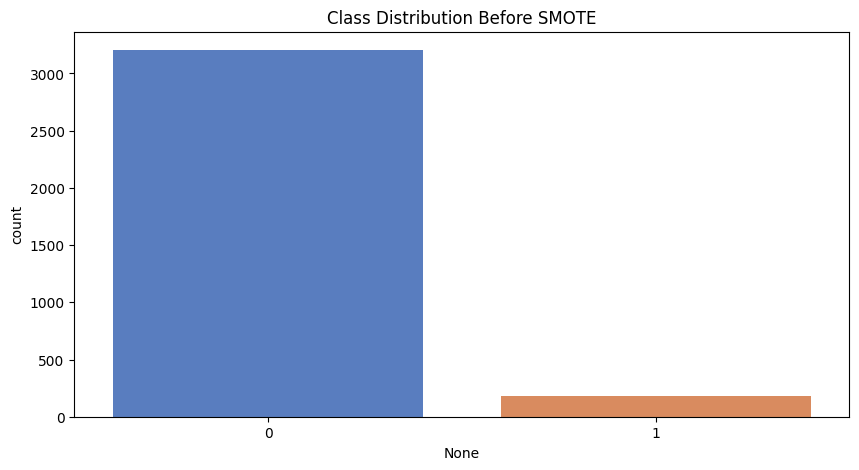

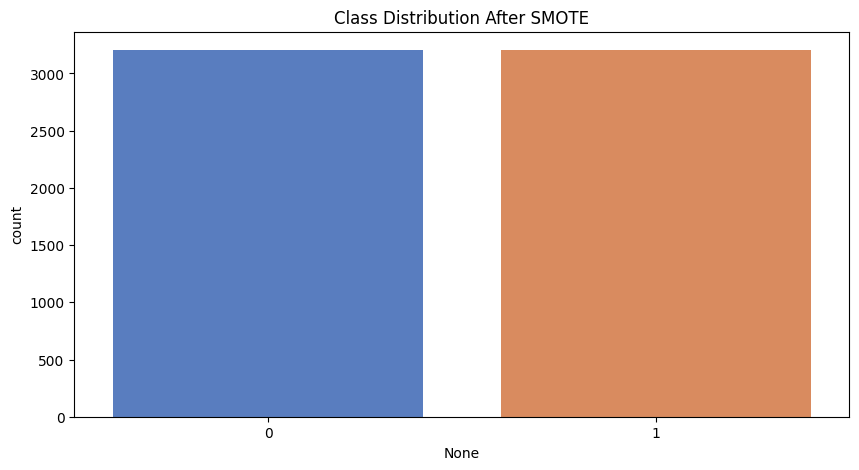


SMOTE Accuracy: 0.86

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.86      0.92      1374
           1       0.28      0.97      0.43        78

    accuracy                           0.86      1452
   macro avg       0.64      0.92      0.68      1452
weighted avg       0.96      0.86      0.90      1452



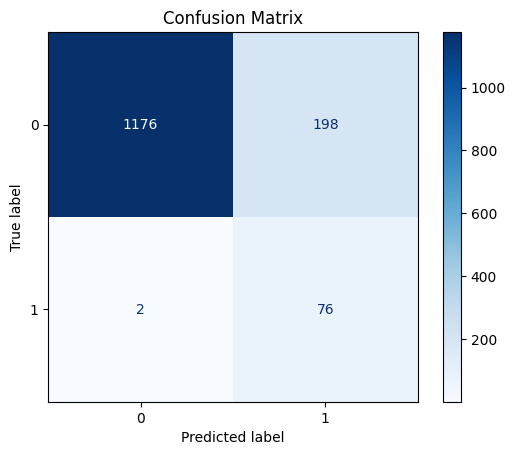

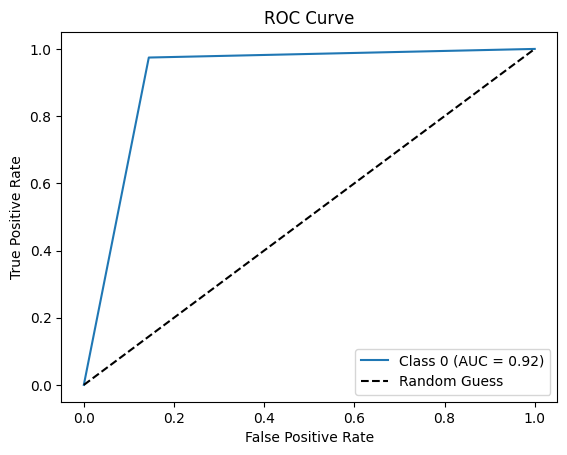


Without SMOTE Accuracy: 0.94

Classification Report:
              precision    recall  f1-score   support

           0       0.95      1.00      0.97      1374
           1       0.00      0.00      0.00        78

    accuracy                           0.94      1452
   macro avg       0.47      0.50      0.49      1452
weighted avg       0.90      0.94      0.92      1452



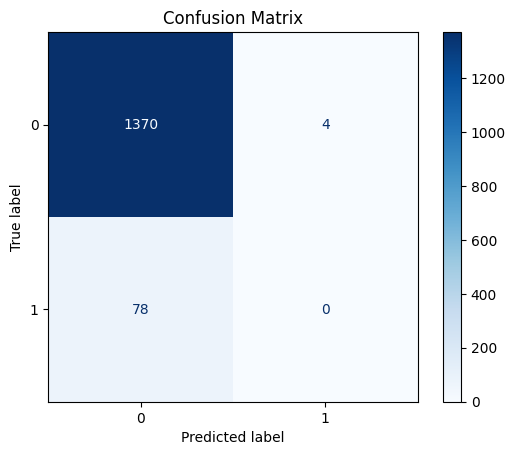

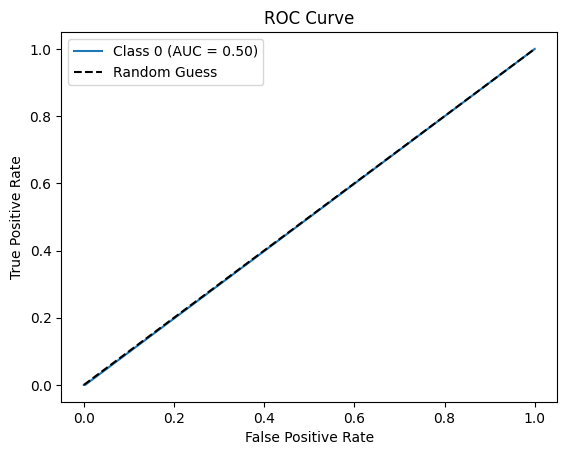

In [35]:
dataset_id = imbalanced_datasets[0]["Dataset ID"]
print("Dataset ID:", dataset_id)
data = openml.datasets.get_dataset(dataset_id)

X, y, _, _ = data.get_data(
    dataset_format="dataframe", target=data.default_target_attribute
)

# Combine X and y for consistent row removal
combined_data = pd.concat([X, y], axis=1)

combined_data_clean = combined_data.dropna()

# Separate X_clean and y_clean
X_clean = combined_data_clean.drop(
    columns=[y.name]
)  # Replace y.name with the actual target column name if different
y_clean = combined_data_clean[y.name]

# Update X and y to cleaned versions
X, y = X_clean, y_clean

# Identify non-numeric columns in X
non_numeric_cols = X.select_dtypes(include=["object", "category"]).columns

# Encode categorical features by converting them to categorical codes
if len(non_numeric_cols) > 0:
    for col in non_numeric_cols:
        X[col] = X[col].astype("category").cat.codes
        print(f"\nEncoded '{col}' with codes:\n", X[col].unique())
    print("\nAfter Encoding Feature dtypes:\n", X.dtypes)
else:
    print("\nNo non-numeric features to encode.")

# Encode target variable using Pandas Categorical Codes if it's non-numeric
if y.dtype == "object" or y.dtype.name == "category":
    y = y.astype("category")
    y_codes = y.cat.codes
    print("\nEncoded Target dtype:", y_codes.dtype)
    print(
        "Target Categories and Codes:\n", dict(zip(y.cat.categories, y_codes.unique()))
    )
    y = y_codes

max_accuracy = 0
max_random_state = 0

random_state = 99

# Split the data with stratification to maintain class distribution
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=random_state, stratify=y
)

# Distribuição antes do SMOTE (antes de qualquer modificação)
plt.figure(figsize=(10, 5))
sns.countplot(x=y_train, palette="muted")  # Usando y_train para as classes do treino
plt.title("Class Distribution Before SMOTE")
plt.show()

# Aplicando SMOTE para balancear as classes
sm = SMOTE(sampling_strategy=1, random_state=random_state)
X_resampled, y_resampled = sm.fit_resample(X_train, y_train)

# Distribuição depois do SMOTE (após balanceamento com SMOTE)
plt.figure(figsize=(10, 5))
sns.countplot(x=y_resampled, palette="muted")  # Usando y_resampled após SMOTE
plt.title("Class Distribution After SMOTE")
plt.show()

# Initialize RandomForest with SMOTE
rf = RandomForest(
    n_estimators=15,
    max_depth=5,
    smote=True,
    random_state=random_state,
)

# Fit the model
rf.fit(X_train, y_train)

# Predict
predictions = rf.predict(X_test)

# Calculate accuracy
accuracy = np.sum(predictions == y_test) / len(y_test)
print(f"\nSMOTE Accuracy: {accuracy:.2f}")

# Calculate precision, recall, and F1 score
report = classification_report(y_test, predictions)

print("\nClassification Report:")
print(report)

# Compute confusion matrix
cm = confusion_matrix(y_test, predictions)

# Display da matriz de confusão
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y))
disp.plot(cmap=plt.cm.Blues, values_format="d")
plt.title("Confusion Matrix")
plt.show()

# Binarize the output for multi-class ROC
y_test_bin = label_binarize(y_test, classes=np.unique(y))
predictions_bin = label_binarize(predictions, classes=np.unique(y))

# Compute ROC curve and AUC for each class
for i in range(y_test_bin.shape[1]):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], predictions_bin[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"Class {i} (AUC = {roc_auc:.2f})")

# Finalize plot
plt.plot([0, 1], [0, 1], "k--", label="Random Guess")
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

# Initialize RandomForest without SMOTE
rf = RandomForest(
    n_estimators=15,
    max_depth=5,
    smote=False,
    random_state=random_state,
)

# Fit the model
rf.fit(X_train, y_train)

# Predict
predictions = rf.predict(X_test)

# Calculate accuracy
accuracy = np.sum(predictions == y_test) / len(y_test)
print(f"\nWithout SMOTE Accuracy: {accuracy:.2f}")

report = classification_report(y_test, predictions)

print("\nClassification Report:")
print(report)

# Previsões do modelo (pode ser com ou sem SMOTE, dependendo de qual você escolher)
predictions = rf.predict(X_test)

# Compute confusion matrix
cm = confusion_matrix(y_test, predictions)

# Display da matriz de confusão
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y))
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Confusion Matrix")
plt.show()

# Binarize the output for multi-class ROC
y_test_bin = label_binarize(y_test, classes=np.unique(y))
predictions_bin = label_binarize(predictions, classes=np.unique(y))

# Compute ROC curve and AUC for each class
for i in range(y_test_bin.shape[1]):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], predictions_bin[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"Class {i} (AUC = {roc_auc:.2f})")

# Finalize plot
plt.plot([0, 1], [0, 1], "k--", label="Random Guess")
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()